# Homework 2: Data storage formats & manipulation (`pandas` and `xarray`)

In [1]:
# Creating the data needed for this assignment (only run once)
%run "HW 2 data generator.py"

In [2]:
import h5py
import os
import numpy as np
import xarray as xr
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 2.1: Loading `hdf5` data and working with data from `xarray` 

In your `data` directory is `animal1_session1.h5`, fake experimental data from an animal running around a behavioral rig for two minutes as it is exposed to stimuli. It includes:

* Behavioral data
    * x,y body position in rig as a function of time
    * x,y whisker position relative to body as a function of time
    * stimulus onset times
    * stimulus offset times
* Ephys data
    * spike times from 2 cells
    
In this problem we'll 
1. use `h5py` to load the data, 
2. construct `xarray` objects,
3. do some math with these, 
4. subsmple these xarrays,
5. and plot our results using `matplotlib`. 
   

In [13]:
### 2.1.1 load this data file as `h5data` using `h5py` 

h5data = h5py.File(os.path.join("data", "animal1_session1.h5"), 'r')
h5data.visit(print)

behavior
behavior/stim_off
behavior/stim_on
behavior/t
behavior/wsk_x
behavior/wsk_y
behavior/x
behavior/y
ephys
ephys/cell1
ephys/cell1/spikes
ephys/cell2
ephys/cell2/spikes


'animal position (X)'

In [15]:
### 2.1.2 Using the data in the h5py file construct two `DataArray` objects.
# one for the body position x-coordinate as `x` using `t` as a coordinate 
# one for the body position y-coordinate as `y` using `t` as a coordinate 
# make sure to include the attributes "long_name" and "units" in the `DataArray`
# (these can be found in the h5py file attributes)
#
# EXTRA CREDIT: read about xarray's `DataSet` object and include BOTH of these
# data sets into one object called `pos`

x = xr.DataArray(h5data["behavior/x"], dims=('t',), coords={'t': h5data["behavior/t"]})
x.attrs["long_name"] = h5data["behavior/x"].attrs["long_name"]
x.attrs["units"] = h5data["behavior/x"].attrs["units"]
x.t.attrs["units"] = h5data["behavior/t"].attrs["units"]

y = xr.DataArray(h5data["behavior/y"], dims=('t',), coords={'t': h5data["behavior/t"]})
y.attrs["long_name"] = h5data["behavior/y"].attrs["long_name"]
y.attrs["units"] = h5data["behavior/y"].attrs["units"]
y.t.attrs["units"] = h5data["behavior/t"].attrs["units"]

In [16]:
x

<xarray.DataArray '/behavior/x' (t: 12000)>
array([-0.04819874, -0.01682922, -0.05104608, ..., -8.38044963,
       -8.29582983, -8.33249287])
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 120.0 120.0 120.0 120.0
Attributes:
    long_name:  animal position (X)
    units:      cm

In [17]:
y

<xarray.DataArray '/behavior/y' (t: 12000)>
array([9.86708294, 9.85014019, 9.76414122, ..., 3.57201978, 3.50202022,
       3.28860399])
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 120.0 120.0 120.0 120.0
Attributes:
    long_name:  animal position (Y)
    units:      cm

In [26]:
# Extra Credit

pos = xr.Dataset({'x': ('t', h5data["behavior/x"]), 'y': ('t', h5data["behavior/y"])}, 
                 coords={'t': h5data["behavior/t"]})

pos.attrs["long_name"] = "animal_position"
pos.x.attrs["long_name"] = h5data["behavior/x"].attrs["long_name"]
pos.x.attrs["units"] = h5data["behavior/x"].attrs["units"]
pos.y.attrs["long_name"] = h5data["behavior/y"].attrs["long_name"]
pos.y.attrs["units"] = h5data["behavior/y"].attrs["units"]
pos.t.attrs["units"] = h5data["behavior/t"].attrs["units"]

In [28]:
pos

<xarray.Dataset>
Dimensions:  (t: 12000)
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 120.0 120.0 120.0 120.0
Data variables:
    x        (t) float64 -0.0482 -0.01683 -0.05105 0.11 ... -8.38 -8.296 -8.332
    y        (t) float64 9.867 9.85 9.764 9.907 ... 3.738 3.572 3.502 3.289
Attributes:
    long_name:  animal_position

In [30]:
### 2.1.3 Using the data in the h5py file construct two more `DataArray` objects.
# one for the relative whisker position x-coordinate as `rel_wsk_x` using `t` as a coordinate 
# one for the relative whisker position y-coordinate as `rel_wsk_y` using `t` as a coordinate 
# make sure to include the attributes "long_name" and "units" in the `DataArray`
# (these can be found in the h5py file attributes)
#
# EXTRA CREDIT: read about xarray's `DataSet` object and include BOTH of these
# data sets into one object called `wsk_pos`
#
# combine these DataArrays with those from the previous problem to create two new
# DataArrays for aboslute whisker position in the rig: 'wsk_x' & `wsk_y'


rel_wsk_x = xr.DataArray(h5data["behavior/wsk_x"], dims=('t',), coords={'t': h5data["behavior/t"]})
rel_wsk_x.attrs["long_name"] = h5data["behavior/wsk_x"].attrs["long_name"]
rel_wsk_x.attrs["units"] = h5data["behavior/wsk_x"].attrs["units"]
rel_wsk_x.t.attrs["units"] = h5data["behavior/t"].attrs["units"]

rel_wsk_y = xr.DataArray(h5data["behavior/wsk_y"], dims=('t',), coords={'t': h5data["behavior/t"]})
rel_wsk_y.attrs["long_name"] = h5data["behavior/wsk_y"].attrs["long_name"]
rel_wsk_y.attrs["units"] = h5data["behavior/wsk_y"].attrs["units"]
rel_wsk_y.t.attrs["units"] = h5data["behavior/t"].attrs["units"]

wsk_x = x + rel_wsk_x
wsk_y = y + rel_wsk_y


In [43]:
### 2.1.4 Now the stimulus information in the h5data to subsample your data:
# Figure out how to grab two time periods from your data: (1) during the 1st
# stimulus presentation (2) for the entire inter-stimulus period between the 
# 1st stimulus onset and the second
# 
# HINT: the stimulus onset and offset times are not explicitly in your "t" coordinate.
# Use the methods we discussed in class to either grab the nearest positions to these 
# times or interpolate from the data that we do have. 


stim_on = np.array(h5data["behavior/stim_on"])
stim_1_on = stim_on[0]
stim_2_on = stim_on[1]
stim_off = np.array(h5data["behavior/stim_off"])
stim_1_off = stim_off[0]

x_1 = x.loc[stim_1_on:stim_2_on]
y_1 = y.loc[stim_1_on:stim_2_on]

wsk_x_1 = wsk_x.loc[stim_1_on:stim_2_on]
wsk_y_1 = wsk_y.loc[stim_1_on:stim_2_on]

x_1_stim = x.loc[stim_1_on:stim_1_off]
y_1_stim = y.loc[stim_1_on:stim_1_off]

wsk_x_1_stim = wsk_x.loc[stim_1_on:stim_1_off]
wsk_y_1_stim = wsk_y.loc[stim_1_on:stim_1_off]

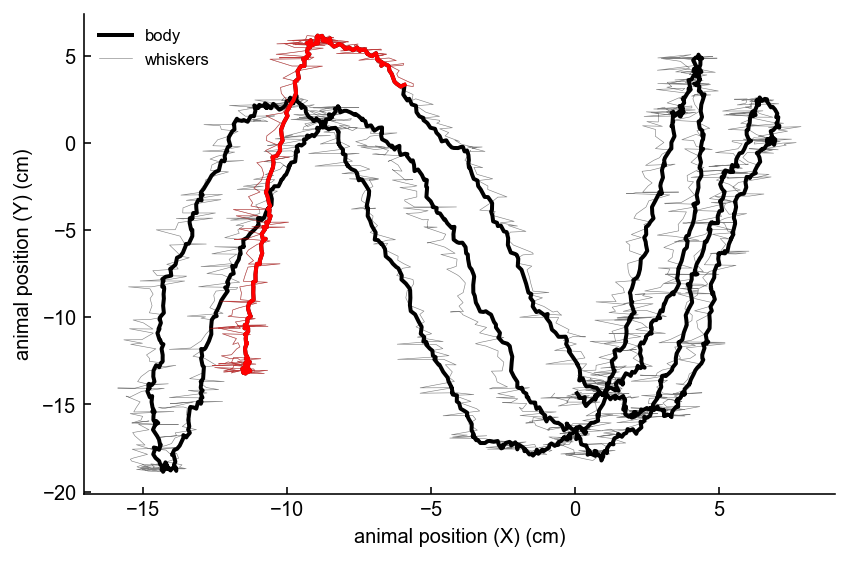

In [52]:
### 2.1.5 Let's plot our data! Make a plot of y position vs x position 
# from the beginning of stimulus 1 to the beginning of stimulus 2.
# Your plot should include 
#
# 1. Axes labels with units
# 2. The animal's body position in the rig
# 3. The animal's whisker position in the rig
# 4. Some kind of annotation (legend, label, etc.) to indicate which curve 
#    is which.  
# 5. Some sort of highllight or emphasis on the stimulus presentation period
#    between stimulus onset and offset.
#
# To the greatest extent possible, pay attention to and modify the style of 
# the graphical elements in the plot assuming the viewer is most interested in
# comparing how the whisker motion changes from during the stimulus to afterwards

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

fig, ax = plt.subplots()
# Plotting the animal's body position during trial 1
ax.plot(x_1, y_1, linewidth=2, color='k', label="body")
# Plotting the animal's whisker using a thinner line
ax.plot(wsk_x_1, y_1, linewidth=0.3, color='k', label="whiskers", alpha=0.5)
# Plotting stimulus period in red
ax.plot(x_1_stim, y_1_stim, linewidth=2, color='r')
ax.plot(wsk_x_1_stim, y_1_stim, linewidth=0.3, color='r', alpha=0.5)

# Setting xes labels
ax.set_xlabel(f"{x.long_name} ({x.units})")
ax.set_ylabel(f"{y.long_name} ({y.units})")
ax.legend()


## Problem 2.2: Saving data to an HDF5 file 

This one is a little more freeform. I want you to think about data from a potetnial experimental session and figure out how you might organize that into an `hdf5` file. 

### 2.2.1 

**Specify what the groups, subgroups, and arrays will be here using markdown**




In [ ]:
### 2.2.2 Use the numpy array consruction methods to  create some fake 
# data variables (as nupy arrays) similar to what you would like to store. 

# this doesn't need to be realistic (it can be all oness) but as much as 
# possible the _shapes_ of the arrays should be as close to reality as you 
# can make it. 










In [ ]:
### 2.2.3 Build your hdf5 file! Make sure to annotate each section and include 
# metadata (including "units" and "long_name" as a minimum)

h5data = h5py.File("your_name_here", ????)

h5data.create_group(?????)
h5data.create_dataset(??????)
#...

# Don't forget to close your data when you are dome!
h5data.close()

## Problem 2.3: Building a `DataFrame` from a series of json files

In this problem we'll be loading behavioral data across animals from a set of json files and manipulating this data in a pandas `DataFrame`. Explicetly, you will 

1. Load behavioral data from a set of `json` files,
2. Create a new pandas `DataFrame` using that data, 
3. Process the datas in pandas to generate a new variable,
4. select groups from your data
5. plot these groups

The experiment consisted of 6 animals (3 male, 3 female) being run through a behavioral assay which resulted in two behavioral scores out of 12: strength and dexterity. Animals were run in 4 behavioral sessions each a week apart. 

Each session for each animal is stored as a `json` file in te directory `behavioral_exp`. The file names are `ANIMAL_NAME-pAGE.json`. Take a look in the directory to make sure this makes sense. 

In [54]:
### 2.3.1 Using package `json` use a for loop and any logic you need to
# load each of these session data files as a dictionary and append them 
# to a list called `behavioral_data`. 
#
# HINT os.listdir(PATH) will return the list of all files in PATH
# Only catch is that it also returns the current directory symbol `.` and 
# the super-directory `..`. You will have to write an if statment to ignore these 
# like 
#
# if not in ['.', '..']:
#      blah....

data_dir = os.path.join("data", "behavioral_exp")

behavioral_data = []
for filename in os.listdir(data_dir):
    if filename not in ['.', '..']:
        with open(os.path.join(data_dir, filename), 'r') as f:
            current_dataset = json.load(f)
        behavioral_data.append(current_dataset)

In [56]:
### 2.3.3 Construct a pandas data frame called `behavior_df` from 
# `behavioral_data`. Compare its entries to the original json files
# to make sure it looks correct. Play around with sampling various 
# parts of the data. 


behavior_df = pd.DataFrame(behavioral_data)
behavior_df

,name,sex,age,strength,dexterity
0,rat2,male,43.0,2.0,8.0
1,rat4,female,44.0,3.0,9.0
2,rat2,male,22.0,5.0,4.0
3,rat3,male,23.0,6.0,4.0
4,rat6,female,21.0,5.0,6.0
5,rat4,female,23.0,7.0,5.0
6,rat2,male,29.0,4.0,7.0
7,rat1,male,36.0,2.0,7.0
8,rat3,male,44.0,2.0,9.0
9,rat5,female,34.0,3.0,9.0


In [57]:
### 2.3.4 add a new column to your `behavior_df` called `meta` 
# which is just the sum of strength and dexterity.

behavior_df["meta"] = behavior_df["strength"] + behavior_df["dexterity"]
behavior_df

,name,sex,age,strength,dexterity,meta
0,rat2,male,43.0,2.0,8.0,10.0
1,rat4,female,44.0,3.0,9.0,12.0
2,rat2,male,22.0,5.0,4.0,9.0
3,rat3,male,23.0,6.0,4.0,10.0
4,rat6,female,21.0,5.0,6.0,11.0
5,rat4,female,23.0,7.0,5.0,12.0
6,rat2,male,29.0,4.0,7.0,11.0
7,rat1,male,36.0,2.0,7.0,9.0
8,rat3,male,44.0,2.0,9.0,11.0
9,rat5,female,34.0,3.0,9.0,12.0


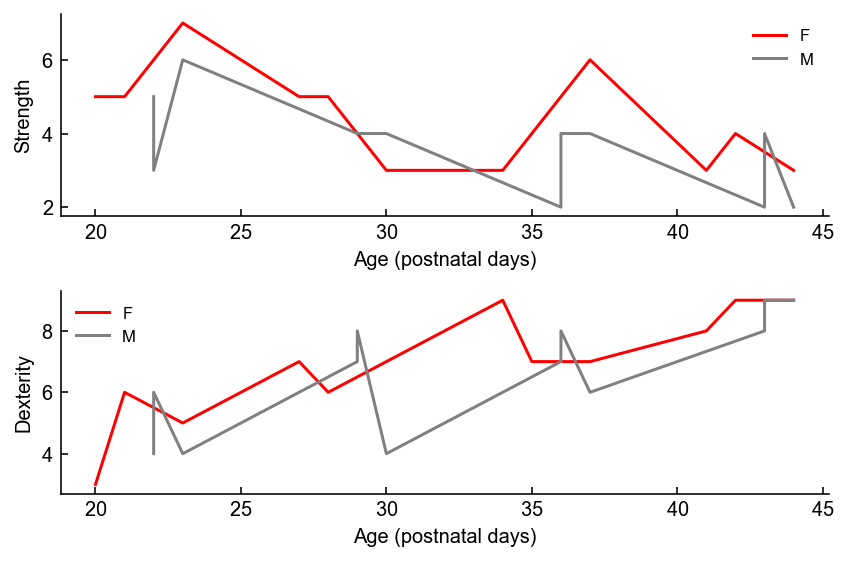

In [71]:
### 2.3.5 Construct a plot with 2 subaxes placed one on top 
# of the other. On the top axis plot strength v. age with two lines 
# one for each sex. On the bottom axis plot dexterity v. age with 
# two lines - one for each sex.
# 
# 1. Axes labels with units
# 2. Some kind of annotation (legend, label, etc.) to indicate which curve 
#    is which.  
#
# To the greatest extent possible, pay attention to and modify the style of 
# the graphical elements in the plot.

fig, (axStr, axDex) = plt.subplots(nrows=2)
male_df = behavior_df[behavior_df["sex"] == 'male']
male_df = male_df.sort_values("age")
female_df = behavior_df[behavior_df["sex"] == 'female']
female_df = female_df.sort_values("age")

axStr.plot(female_df["age"], female_df["strength"], color='r', label="F")
axStr.plot(male_df["age"], male_df["strength"], color='grey', label="M")
axStr.set_ylabel("Strength")
axStr.set_xlabel("Age (postnatal days)")
axStr.legend()


axDex.plot(female_df["age"], female_df["dexterity"], color='r', label="F")
axDex.plot(male_df["age"], male_df["dexterity"], color='grey', label="M")
axDex.set_ylabel("Dexterity")
axDex.set_xlabel("Age (postnatal days)")
axDex.legend()                                   